In [9]:
# # #Uncomment this in case you're missing some of them
# !pip3 install Box2D
# !pip3 install box2d-py
# !pip3 install gym[all]
# !pip3 install gym[Box_2D]





In [10]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import collections
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [11]:
#3 layer neural network,that receives an input and produces vector of four  numbers(actions)
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions,device="cpu"):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(input_shape[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_actions)
        self.device=device
    def forward(self, x):
          x=x.to(self.device)
          x = self.fc1(x)
          x = F.relu(x)
          x = self.fc2(x)
          x = F.relu(x)
          x = self.fc3(x)
          x = F.relu(x)
          return self.fc4(x)


In [12]:

env = gym.make('LunarLander-v2')
GAMMA = 0.99
BATCH_SIZE =64
REPLAY_SIZE = int(1e5)
LEARNING_RATE = 7e-4
SYNC_TARGET_FRAMES = 100
REPLAY_START_SIZE = 100
EPSILON_START = 1.0
EPS_END = 0.01
EPS_DECAY_RATE = 0.997

Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

PRIO_REPLAY_ALPHA = 0.6




class PrioReplayBufferList:
    def __init__(self, buf_size, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity = buf_size
        self.pos = 0
        self.buffer = []
        self.priorities = np.zeros((buf_size, ), dtype=np.float32)

    def __len__(self):
        return len(self.buffer)

    def append(self, sample):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(sample)
        else:
            self.buffer[self.pos] = sample
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = np.array(prios, dtype=np.float32) ** self.prob_alpha

        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=True)
        #samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        samples=np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.uint8), np.array(next_states)

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

In [13]:
import itertools
class Agent:
    def __init__(self, env, exp_buffer,double=False):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()
        self.double = double
    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0, device="cuda"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        #self.exp_buffer.populate(1)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

def calc_loss(batch,batch_weights,net, tgt_net, double,device="cuda"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(np.array(states, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(next_states, copy=False)).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)
    batch_weights_v = torch.tensor(batch_weights).to(device)
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
   
    with torch.no_grad():
        if(not double): next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_acts = net(next_states_v).max(1)[1]
        next_state_acts = next_state_acts.unsqueeze(-1)
        if(double): next_state_values = tgt_net(next_states_v).gather(1, next_state_acts).squeeze(-1)
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    next_states_v = torch.tensor(next_states).to(device)
    expected_state_action_values = next_state_values * GAMMA + rewards_v
    losses_v = batch_weights_v * (state_action_values - expected_state_action_values) ** 2
    return losses_v.mean(), losses_v + 1e-5
    #return nn.MSELoss()(state_action_values, expected_state_action_values)



In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DQN(env.observation_space.shape, env.action_space.n,device).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n,device).to(device)

buffer =PrioReplayBufferList(REPLAY_SIZE)
#Creating DQN agent 
#set double==True to train double DQN 
agent = Agent(env, buffer,double=True)
eps = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

buf_m_reward = []
buf_loss = []
BETA_START = 0.4
BETA_INCR_RATE=1.02
beta=BETA_START
while True:
    frame_idx += 1
    reward = agent.play_step(net, eps, device=device)
    if reward is not None:
        eps = max(EPS_END, EPS_DECAY_RATE * eps)
        beta = min(1.0, beta*BETA_INCR_RATE)
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        if(int(len(total_rewards))%100==0):
          print("%d: done %d games, reward %.3f, "
                "eps %.2f, speed %.2f f/s" % (
              frame_idx, len(total_rewards), m_reward, eps,
              speed
          ))
        buf_m_reward.append(m_reward)
        if best_m_reward is None or best_m_reward < m_reward:
            if(m_reward>190): torch.save(net.state_dict(), "mountain" + "-best_%.0f.dat" % m_reward)
            best_m_reward = m_reward
        if m_reward > 200:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE: continue

    if frame_idx % SYNC_TARGET_FRAMES == 0: tgt_net.load_state_dict(net.state_dict())                    

    optimizer.zero_grad()
    batch, batch_indices, batch_weights = buffer.sample(BATCH_SIZE, beta)
    #batch = buffer.sample(BATCH_SIZE)
    #loss_t = calc_loss(batch, net, tgt_net, double=agent.double,device=device)
    #print(batch)
    #print(batch[0].shape)
    loss_t, sample_prios_v = calc_loss(batch, batch_weights, net, tgt_net,
                                               double=agent.double, device=device)
    loss_t.backward()
    optimizer.step()
    buffer.update_priorities(batch_indices, sample_prios_v.data.cpu().numpy())
    buf_loss.append(loss_t)

8923: done 100 games, reward -201.355, eps 0.74, speed 417.14 f/s
22940: done 200 games, reward -126.469, eps 0.55, speed 306.71 f/s
53614: done 300 games, reward -80.155, eps 0.41, speed 218.56 f/s
107333: done 400 games, reward -36.092, eps 0.30, speed 142.68 f/s
183890: done 500 games, reward 35.338, eps 0.22, speed 164.72 f/s
255724: done 600 games, reward 128.742, eps 0.16, speed 195.09 f/s
302882: done 700 games, reward 135.661, eps 0.12, speed 211.65 f/s
340075: done 800 games, reward 184.228, eps 0.09, speed 219.48 f/s
Solved in 352875 frames!


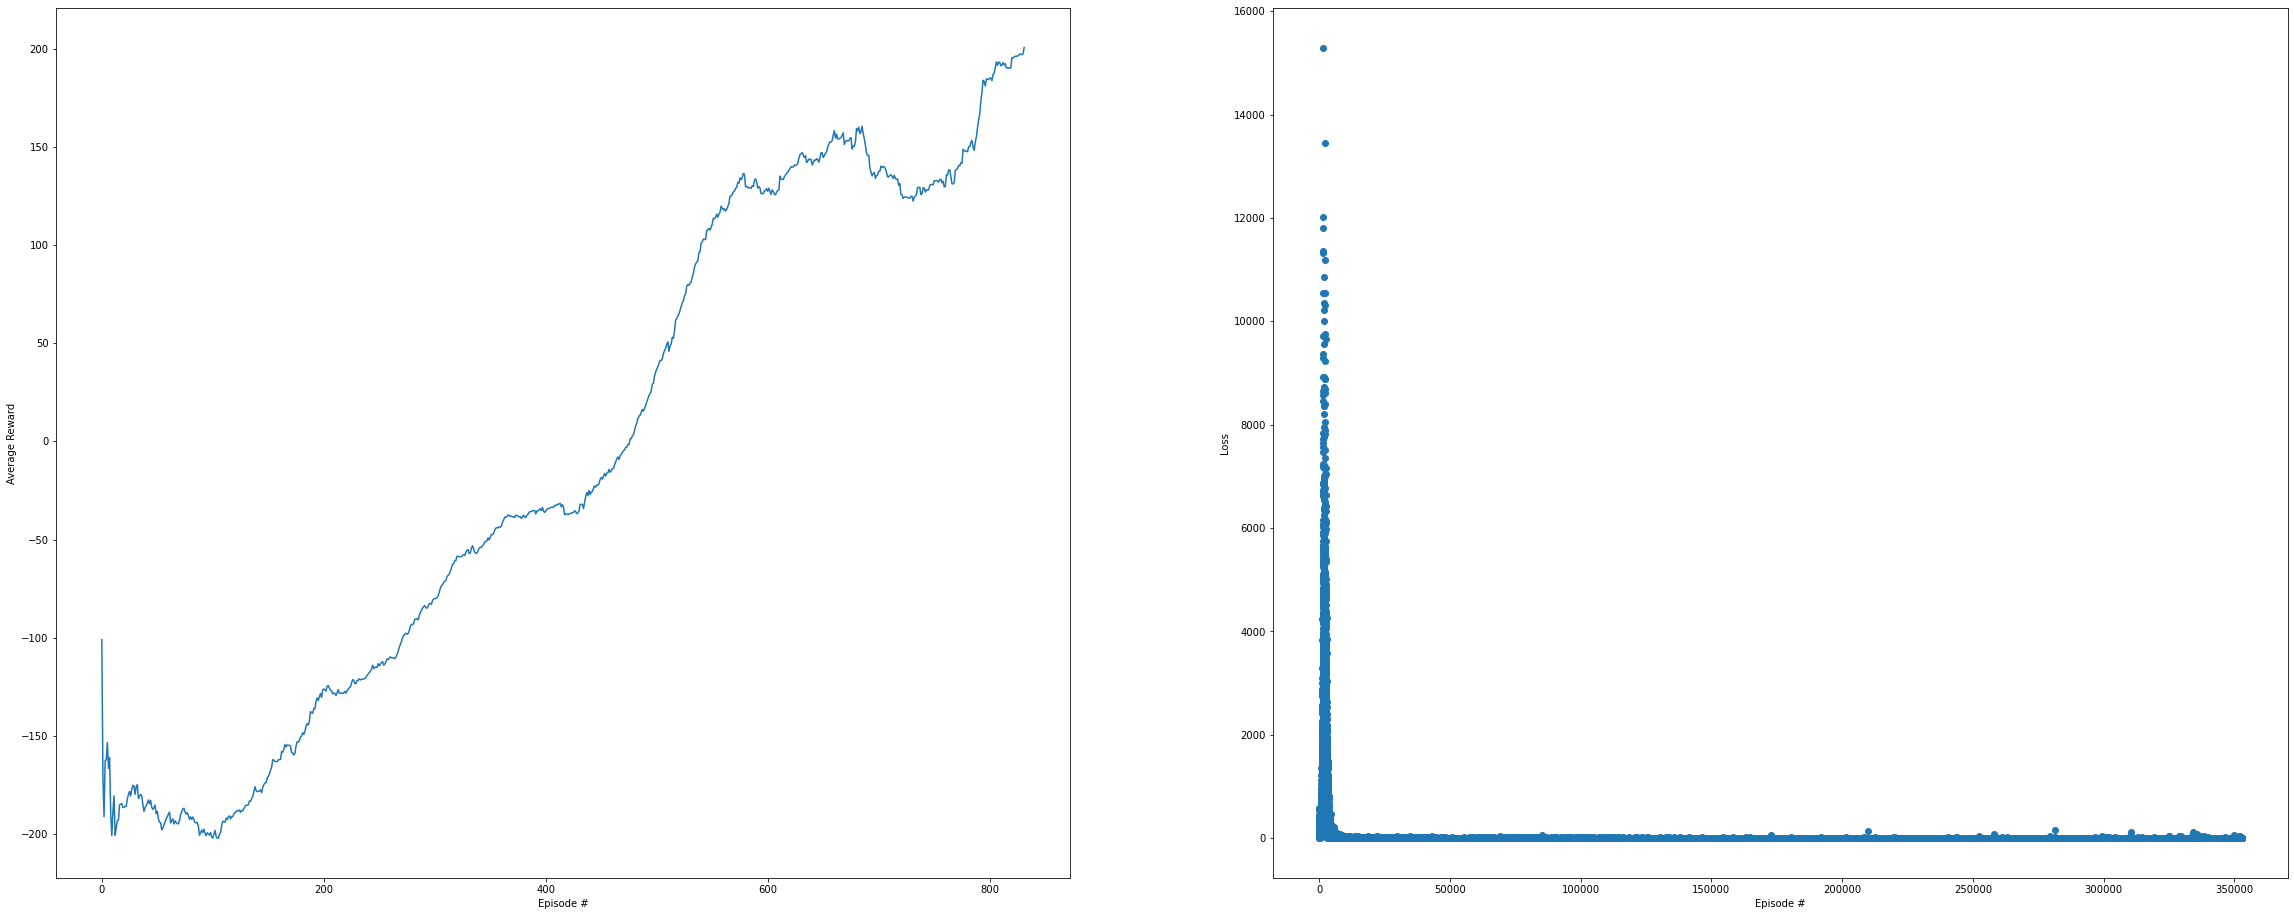

In [15]:
# plot the scores
plt.figure(figsize=(40,16))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(buf_m_reward)), buf_m_reward)
plt.ylabel('Average Reward')
plt.xlabel('Episode #')
#plt.show()
# pot the scores
plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(buf_loss)), [b.detach().cpu().numpy() for b in buf_loss])
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()